## ===== IMPORTS =====

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## ===== WEIGHT INITIALIZER =====

In [2]:
class WeightInitializer:
    """Weight initialization methods"""
    
    def __init__(self, method='xavier'):
        self.method = method
    
    def initialize(self, *shape):
        if self.method == 'xavier':
            # Xavier/Glorot initialization
            std = np.sqrt(2.0 / sum(shape))
            return np.random.randn(*shape) * std
        elif self.method == 'he':
            # He initialization (for ReLU)
            std = np.sqrt(2.0 / shape[0])
            return np.random.randn(*shape) * std
        else:
            # Random initialization
            return np.random.randn(*shape) * 0.1

## ===== EARLY STOPPING =====

In [3]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    
    def __init__(self, patience=7, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
    
    def __call__(self, val_loss):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

## ===== PLOT MANAGER =====

In [4]:
class PlotManager:
    """Manages plotting of training progress"""
    
    def plot_losses(self, train_losses, val_losses):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
        if val_losses:
            plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
        if val_losses:
            plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
        plt.title('Training Loss (Log Scale)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## ===== LSTM FROM SCRATCH =====

In [5]:
class LSTM:
    """
    Long Short-Term Memory (LSTM) network implemented from scratch.
    
    Parameters:
    - input_size: int, dimensionality of input space
    - hidden_size: int, number of LSTM units  
    - output_size: int, dimensionality of output space
    - init_method: str, weight initialization method
    """
    
    def __init__(self, input_size, hidden_size, output_size, init_method='xavier'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_initializer = WeightInitializer(method=init_method)
        
        # Initialize LSTM weights
        # Forget gate weights
        self.wf = self.weight_initializer.initialize(hidden_size, hidden_size + input_size)
        self.bf = np.zeros((hidden_size, 1))
        
        # Input gate weights
        self.wi = self.weight_initializer.initialize(hidden_size, hidden_size + input_size)
        self.bi = np.zeros((hidden_size, 1))
        
        # Output gate weights
        self.wo = self.weight_initializer.initialize(hidden_size, hidden_size + input_size)
        self.bo = np.zeros((hidden_size, 1))
        
        # Cell gate weights
        self.wc = self.weight_initializer.initialize(hidden_size, hidden_size + input_size)
        self.bc = np.zeros((hidden_size, 1))
        
        # Output layer weights
        self.why = self.weight_initializer.initialize(output_size, hidden_size)
        self.by = np.zeros((output_size, 1))
    
    @staticmethod
    def sigmoid(z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))  # Clip to prevent overflow
    
    @staticmethod
    def dsigmoid(y):
        """Derivative of sigmoid function"""
        return y * (1 - y)
    
    @staticmethod
    def dtanh(y):
        """Derivative of tanh function"""
        return 1 - y * y
    
    def forward(self, x):
        """
        Forward pass through LSTM
        
        Parameters:
        - x: np.ndarray, input sequence of shape (time_steps, input_size)
        
        Returns:
        - y: np.ndarray, output
        - caches: list, intermediate values for backpropagation
        """
        caches = []
        h_prev = np.zeros((self.hidden_size, 1))
        c_prev = np.zeros((self.hidden_size, 1))
        
        # Process each time step
        for t in range(x.shape[0]):
            x_t = x[t].reshape(-1, 1)
            
            # Combine previous hidden state with current input
            combined = np.vstack((h_prev, x_t))
            
            # LSTM gates
            f = self.sigmoid(np.dot(self.wf, combined) + self.bf)  # Forget gate
            i = self.sigmoid(np.dot(self.wi, combined) + self.bi)  # Input gate
            o = self.sigmoid(np.dot(self.wo, combined) + self.bo)  # Output gate
            c_ = np.tanh(np.dot(self.wc, combined) + self.bc)      # Candidate cell state
            
            # Update cell state and hidden state
            c = f * c_prev + i * c_
            h = o * np.tanh(c)
            
            # Store intermediate values for backpropagation
            cache = (h_prev, c_prev, f, i, o, c_, x_t, combined, c, h)
            caches.append(cache)
            
            # Update for next time step
            h_prev, c_prev = h, c
        
        # Final output
        y = np.dot(self.why, h) + self.by
        return y, caches
    
    def backward(self, dy, caches, clip_value=1.0):
        """
        Backward pass through LSTM (Backpropagation Through Time)
        """
        # Initialize gradients
        dWf, dWi, dWo, dWc = [np.zeros_like(w) for w in [self.wf, self.wi, self.wo, self.wc]]
        dbf, dbi, dbo, dbc = [np.zeros_like(b) for b in [self.bf, self.bi, self.bo, self.bc]]
        dWhy = np.zeros_like(self.why)
        dby = np.zeros_like(self.by)
        
        dy = dy.reshape(self.output_size, -1)
        dh_next = np.zeros((self.hidden_size, 1))
        dc_next = np.zeros((self.hidden_size, 1))
        
        # Backpropagate through time
        for cache in reversed(caches):
            h_prev, c_prev, f, i, o, c_, x_t, combined, c, h = cache
            
            # Gradient from output and next hidden state
            dh = np.dot(self.why.T, dy) + dh_next
            dc = dc_next + (dh * o * self.dtanh(np.tanh(c)))
            
            # Gate gradients
            df = dc * c_prev * self.dsigmoid(f)
            di = dc * c_ * self.dsigmoid(i)
            do = dh * np.tanh(c) * self.dsigmoid(o)
            dc_ = dc * i * self.dtanh(c_)
            
            # Combined gradients
            dcombined_f = np.dot(self.wf.T, df)
            dcombined_i = np.dot(self.wi.T, di)
            dcombined_o = np.dot(self.wo.T, do)
            dcombined_c = np.dot(self.wc.T, dc_)
            
            dcombined = dcombined_f + dcombined_i + dcombined_o + dcombined_c
            dh_next = dcombined[:self.hidden_size]
            dc_next = f * dc
            
            # Weight gradients
            dWf += np.dot(df, combined.T)
            dWi += np.dot(di, combined.T)
            dWo += np.dot(do, combined.T)
            dWc += np.dot(dc_, combined.T)
            
            # Bias gradients
            dbf += df
            dbi += di
            dbo += do
            dbc += dc_
        
        # Output layer gradients
        dWhy += np.dot(dy, h.T)
        dby += dy
        
        gradients = (dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby)
        
        # Gradient clipping
        for i in range(len(gradients)):
            np.clip(gradients[i], -clip_value, clip_value, out=gradients[i])
        
        return gradients
    
    def update_params(self, grads, learning_rate):
        """Update parameters using gradients"""
        dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby = grads
        
        # Update LSTM weights
        self.wf -= learning_rate * dWf
        self.wi -= learning_rate * dWi
        self.wo -= learning_rate * dWo
        self.wc -= learning_rate * dWc
        
        # Update LSTM biases
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc
        
        # Update output layer
        self.why -= learning_rate * dWhy
        self.by -= learning_rate * dby

🧠 LSTM Neural Network Architecture


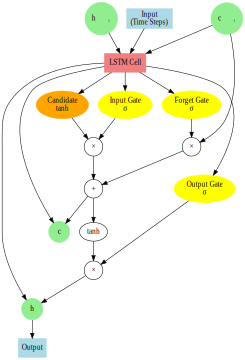

In [6]:
# ===== INSTALL GRAPHVIZ =====
!apt-get install graphviz -qq
!pip install graphviz pydot

import graphviz
from graphviz import Digraph

def draw_lstm_architecture():
    """Draw LSTM architecture using Graphviz"""
    dot = Digraph(comment='LSTM Architecture')
    dot.attr(rankdir='TB', size='8,5')
    
    # Input layer
    dot.node('X', 'Input\n(Time Steps)', shape='box', style='filled', color='lightblue')
    
    # LSTM Cell components
    dot.node('LSTM', 'LSTM Cell', shape='box', style='filled', color='lightcoral')
    dot.node('h_prev', 'hₜ₋₁', shape='circle', style='filled', color='lightgreen')
    dot.node('c_prev', 'cₜ₋₁', shape='circle', style='filled', color='lightgreen')
    dot.node('h_next', 'hₜ', shape='circle', style='filled', color='lightgreen')
    dot.node('c_next', 'cₜ', shape='circle', style='filled', color='lightgreen')
    
    # Gates
    dot.node('f', 'Forget Gate\nσ', shape='ellipse', style='filled', color='yellow')
    dot.node('i', 'Input Gate\nσ', shape='ellipse', style='filled', color='yellow')
    dot.node('o', 'Output Gate\nσ', shape='ellipse', style='filled', color='yellow')
    dot.node('c_candidate', 'Candidate\n tanh', shape='ellipse', style='filled', color='orange')
    
    # Operations
    dot.node('mult1', '×', shape='circle')
    dot.node('mult2', '×', shape='circle')
    dot.node('mult3', '×', shape='circle')
    dot.node('add1', '+', shape='circle')
    dot.node('tanh1', 'tanh', shape='ellipse')
    
    # Output
    dot.node('Y', 'Output', shape='box', style='filled', color='lightblue')
    
    # Connections
    dot.edge('X', 'LSTM')
    dot.edge('h_prev', 'LSTM')
    dot.edge('c_prev', 'LSTM')
    dot.edge('LSTM', 'h_next')
    dot.edge('LSTM', 'c_next')
    dot.edge('h_next', 'Y')
    
    # Internal LSTM connections (simplified)
    dot.edge('LSTM', 'f')
    dot.edge('LSTM', 'i')
    dot.edge('LSTM', 'o')
    dot.edge('LSTM', 'c_candidate')
    dot.edge('f', 'mult1')
    dot.edge('c_prev', 'mult1')
    dot.edge('i', 'mult2')
    dot.edge('c_candidate', 'mult2')
    dot.edge('mult1', 'add1')
    dot.edge('mult2', 'add1')
    dot.edge('add1', 'c_next')
    dot.edge('add1', 'tanh1')
    dot.edge('tanh1', 'mult3')
    dot.edge('o', 'mult3')
    dot.edge('mult3', 'h_next')
    
    return dot

# Display architecture
print("🧠 LSTM Neural Network Architecture")
lstm_arch = draw_lstm_architecture()
lstm_arch

## ===== LSTM TRAINER =====

In [7]:
class LSTMTrainer:
    """Trainer for LSTM model"""
    
    def __init__(self, model, learning_rate=0.01, patience=7, verbose=True, delta=0):
        self.model = model
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        self.early_stopping = EarlyStopping(patience, verbose, delta)
    
    def compute_loss(self, y_pred, y_true):
        """Mean Squared Error loss"""
        return np.mean((y_pred - y_true) ** 2)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=1, clip_value=1.0):
        """Train the LSTM model"""
        print(f"🚀 Training LSTM for {epochs} epochs...")
        
        for epoch in range(epochs):
            epoch_losses = []
            
            # Mini-batch training
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                batch_losses = []
                
                for x, y_true in zip(batch_X, batch_y):
                    # Forward pass
                    y_pred, caches = self.model.forward(x)
                    loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
                    batch_losses.append(loss)
                    
                    # Backward pass
                    dy = y_pred - y_true.reshape(-1, 1)
                    grads = self.model.backward(dy, caches, clip_value)
                    self.model.update_params(grads, self.learning_rate)
                
                batch_loss = np.mean(batch_losses)
                epoch_losses.append(batch_loss)
            
            avg_epoch_loss = np.mean(epoch_losses)
            self.train_losses.append(avg_epoch_loss)
            
            # Validation
            if X_val is not None and y_val is not None:
                val_loss = self.validate(X_val, y_val)
                self.val_losses.append(val_loss)
                
                if epoch % 10 == 0:
                    print(f'Epoch {epoch + 1:3d}/{epochs} - Loss: {avg_epoch_loss:.5f}, Val Loss: {val_loss:.5f}')
                
                # Early stopping check
                self.early_stopping(val_loss)
                if self.early_stopping.early_stop:
                    print("🛑 Early stopping triggered!")
                    break
            else:
                if epoch % 10 == 0:
                    print(f'Epoch {epoch + 1:3d}/{epochs} - Loss: {avg_epoch_loss:.5f}')
    
    def validate(self, X_val, y_val):
        """Validate the model"""
        val_losses = []
        for x, y_true in zip(X_val, y_val):
            y_pred, _ = self.model.forward(x)
            loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
            val_losses.append(loss)
        return np.mean(val_losses)

## ===== TIME SERIES DATASET =====

In [8]:
class TimeSeriesDataset:
    """Dataset for time series forecasting"""
    
    def __init__(self, look_back=1, train_size=0.67):
        self.look_back = look_back
        self.train_size = train_size
        self.scaler = MinMaxScaler()
    
    def create_synthetic_data(self, n_points=1000):
        """Create synthetic sine wave data for demonstration"""
        print("📊 Creating synthetic time series data...")
        
        t = np.linspace(0, 4*np.pi, n_points)
        data = np.sin(t) + 0.1 * np.random.randn(n_points)  # Sine wave with noise
        
        # Normalize data
        data = self.scaler.fit_transform(data.reshape(-1, 1)).flatten()
        
        train_size = int(len(data) * self.train_size)
        train, test = data[:train_size], data[train_size:]
        
        return train, test
    
    def create_dataset(self, data):
        """Create time series dataset with lookback window"""
        dataX, dataY = [], []
        for i in range(len(data) - self.look_back):
            dataX.append(data[i:(i + self.look_back)])
            dataY.append(data[i + self.look_back])
        return np.array(dataX), np.array(dataY)
    
    def get_train_test(self):
        """Get training and testing data"""
        train, test = self.create_synthetic_data()
        trainX, trainY = self.create_dataset(train)
        testX, testY = self.create_dataset(test)
        
        print(f"Training samples: {trainX.shape[0]}")
        print(f"Test samples: {testX.shape[0]}")
        print(f"Lookback window: {self.look_back}")
        
        return trainX, trainY, testX, testY

## ===== MAIN EXECUTION =====

🧠 LSTM from Scratch - Time Series Forecasting
📊 Creating synthetic time series data...
Training samples: 790
Test samples: 190
Lookback window: 10

📦 Data Shapes:
Train X: (790, 10, 1), Train Y: (790,)
Test X: (190, 10, 1), Test Y: (190,)

🏗️ LSTM Architecture:
Input size: 1, Hidden size: 50, Output size: 1
Total parameters: ~10,250
🚀 Training LSTM for 200 epochs...
Epoch   1/200 - Loss: 0.00807, Val Loss: 0.02279
Epoch  11/200 - Loss: 0.00281, Val Loss: 0.00775
Epoch  21/200 - Loss: 0.00241, Val Loss: 0.00422
Epoch  31/200 - Loss: 0.00232, Val Loss: 0.00333
Epoch  41/200 - Loss: 0.00230, Val Loss: 0.00305
Epoch  51/200 - Loss: 0.00229, Val Loss: 0.00292
Epoch  61/200 - Loss: 0.00228, Val Loss: 0.00284
Epoch  71/200 - Loss: 0.00228, Val Loss: 0.00279
Epoch  81/200 - Loss: 0.00228, Val Loss: 0.00274
Epoch  91/200 - Loss: 0.00228, Val Loss: 0.00271
Epoch 101/200 - Loss: 0.00228, Val Loss: 0.00268
Epoch 111/200 - Loss: 0.00228, Val Loss: 0.00265
Epoch 121/200 - Loss: 0.00228, Val Loss: 0.

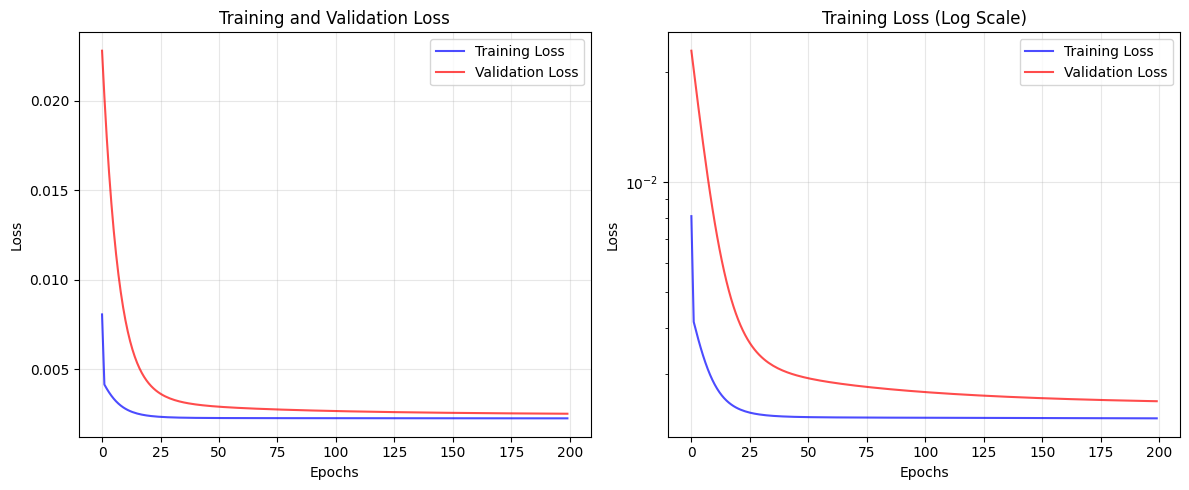


🔮 Making predictions...


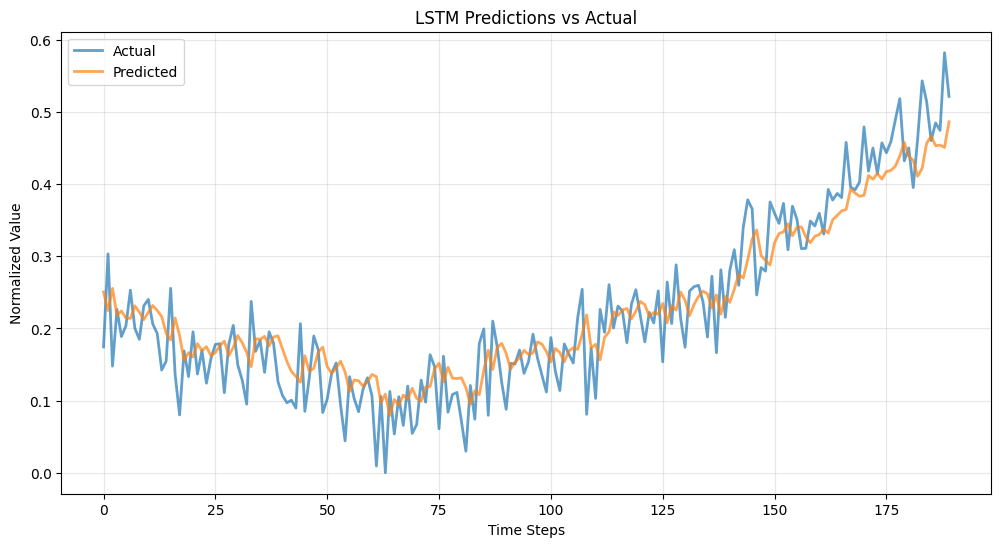


📊 Final Performance:
Test MSE: 0.002527
Test RMSE: 0.050273

✅ LSTM Training Completed Successfully!


In [9]:
if __name__ == "__main__":
    print("🧠 LSTM from Scratch - Time Series Forecasting")
    print("=" * 50)
    
    # Create dataset
    dataset = TimeSeriesDataset(look_back=10, train_size=0.8)
    trainX, trainY, testX, testY = dataset.get_train_test()
    
    # Reshape data for LSTM (samples, time_steps, features)
    trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
    testX = testX.reshape(testX.shape[0], testX.shape[1], 1)
    
    print(f"\n📦 Data Shapes:")
    print(f"Train X: {trainX.shape}, Train Y: {trainY.shape}")
    print(f"Test X: {testX.shape}, Test Y: {testY.shape}")
    
    # Create LSTM model
    hidden_size = 50
    output_size = 1
    
    lstm = LSTM(input_size=1, hidden_size=hidden_size, output_size=output_size)
    
    print(f"\n🏗️ LSTM Architecture:")
    print(f"Input size: 1, Hidden size: {hidden_size}, Output size: {output_size}")
    print(f"Total parameters: ~{(hidden_size * (hidden_size + 1) * 4 + (hidden_size * output_size)):,}")
    
    # Train model
    trainer = LSTMTrainer(lstm, learning_rate=0.01, patience=20, verbose=True)
    trainer.train(trainX, trainY, testX, testY, epochs=200, batch_size=16)
    
    # Plot results
    plot_manager = PlotManager()
    plot_manager.plot_losses(trainer.train_losses, trainer.val_losses)
    
    # Make predictions
    print("\n🔮 Making predictions...")
    predictions = []
    for x in testX:
        y_pred, _ = lstm.forward(x)
        predictions.append(y_pred[0, 0])
    
    predictions = np.array(predictions)
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(testY, label='Actual', alpha=0.7, linewidth=2)
    plt.plot(predictions, label='Predicted', alpha=0.7, linewidth=2)
    plt.title('LSTM Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate final metrics
    mse = np.mean((predictions - testY) ** 2)
    print(f"\n📊 Final Performance:")
    print(f"Test MSE: {mse:.6f}")
    print(f"Test RMSE: {np.sqrt(mse):.6f}")
    
    print("\n✅ LSTM Training Completed Successfully!")